# Get WaffleIron Model

In [1]:
from models.waffleiron.segmenter import Segmenter

Using torch.scatter_reduce for 3D to 2D projection.
Using torch.scatter_reduce for 3D to 2D projection.


In [2]:
model = Segmenter(
    input_channels=5,
    feat_channels=768,
    depth=48,
    grid_shape=[[256, 256], [256, 32], [256, 32]],
    nb_class=16, # class for prediction
    #drop_path_prob=config["waffleiron"]["drop_path"],
    layer_norm=True,
)

In [3]:
import torch

# Load pretrained model
ckpt = torch.load('/root/main/ScaLR/saved_models/ckpt_last_scalr.pth', map_location="cuda:0")
ckpt = ckpt["net"]

/tmp/ipykernel_84939/235293898.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('/root/main/ScaLR/saved_models/ckpt_last_scalr.pth', map_location="cuda:

In [4]:
print(ckpt.keys())

dict_keys(['module.embed.norm.weight', 'module.embed.norm.bias', 'module.embed.norm.running_mean', 'module.embed.norm.running_var', 'module.embed.norm.num_batches_tracked', 'module.embed.conv1.weight', 'module.embed.conv1.bias', 'module.embed.conv2.0.weight', 'module.embed.conv2.0.bias', 'module.embed.conv2.0.running_mean', 'module.embed.conv2.0.running_var', 'module.embed.conv2.0.num_batches_tracked', 'module.embed.conv2.1.weight', 'module.embed.conv2.2.weight', 'module.embed.conv2.2.bias', 'module.embed.conv2.2.running_mean', 'module.embed.conv2.2.running_var', 'module.embed.conv2.2.num_batches_tracked', 'module.embed.conv2.4.weight', 'module.embed.final.weight', 'module.embed.final.bias', 'module.waffleiron.channel_mix.0.scale.weight', 'module.waffleiron.channel_mix.0.norm.weight', 'module.waffleiron.channel_mix.0.norm.bias', 'module.waffleiron.channel_mix.0.mlp.0.weight', 'module.waffleiron.channel_mix.0.mlp.0.bias', 'module.waffleiron.channel_mix.0.mlp.2.weight', 'module.waffleiro

In [5]:
new_ckpt = {}
for k in ckpt.keys():
    if k.startswith("module"):
        if k.startswith("module.classif.0"):
            continue
        elif k.startswith("module.classif.1"):
            new_ckpt["classif" + k[len("module.classif.1") :]] = ckpt[k]
        else:
            new_ckpt[k[len("module.") :]] = ckpt[k]
    else:
        new_ckpt[k] = ckpt[k]

In [6]:
new_ckpt.get("classif.weight").shape

torch.Size([16, 768, 1])

In [7]:
model.load_state_dict(new_ckpt)

<All keys matched successfully>

## Model Forward

In [8]:
torch.cuda.set_device("cuda:0")
model = model.cuda("cuda:0")

In [9]:
model.eval()

Segmenter(
  (embed): Embedding(
    (norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv1d(5, 768, kernel_size=(1,), stride=(1,))
    (conv2): Sequential(
      (0): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(5, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU(inplace=True)
      (4): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (final): Conv1d(1536, 768, kernel_size=(1,), stride=(1,))
  )
  (waffleiron): WaffleIron(
    (channel_mix): ModuleList(
      (0-47): 48 x ChannelMix(
        (norm): myLayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
          (1): ReLU(inplace=True)
          (2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
        )
 

## Nuscenes

In [10]:
import torch
import numpy as np
import utils.transforms as tr
from torch.utils.data import Dataset
from scipy.spatial import cKDTree as KDTree

class PCDataset(Dataset):
    def __init__(
        self,
        rootdir=None,
        phase="train",
        input_feat="intensity",
        voxel_size=0.1,
        train_augmentations=None,
        dim_proj=[
            0,
        ],
        grids_shape=[(256, 256)],
        fov_xyz=(
            (-1.0, -1.0, -1.0),
            (1.0, 1.0, 1.0),
        ),
        num_neighbors=16,
    ):
        super().__init__()

        # Dataset split
        self.phase = phase
        assert self.phase in ["train", "val", "trainval", "test"]

        # Root directory of dataset
        self.rootdir = rootdir

        # Input features to compute for each point
        self.input_feat = input_feat

        # Downsample input point cloud by small voxelization
        self.downsample = tr.Voxelize(
            dims=(0, 1, 2),
            voxel_size=voxel_size,
            random=(self.phase == "train" or self.phase == "trainval"),
        )

        # Field of view
        assert len(fov_xyz[0]) == len(
            fov_xyz[1]
        ), "Min and Max FOV must have the same length."
        for i, (min, max) in enumerate(zip(*fov_xyz)):
            assert (
                min < max
            ), f"Field of view: min ({min}) < max ({max}) is expected on dimension {i}."
        self.fov_xyz = np.concatenate([np.array(f)[None] for f in fov_xyz], axis=0)
        self.crop_to_fov = tr.Crop(dims=(0, 1, 2), fov=fov_xyz)

        # Grid shape for projection in 2D
        assert len(grids_shape) == len(dim_proj)
        self.dim_proj = dim_proj
        self.grids_shape = [np.array(g) for g in grids_shape]
        self.lut_axis_plane = {0: (1, 2), 1: (0, 2), 2: (0, 1)}

        # Number of neighbors for embedding layer
        assert num_neighbors > 0
        self.num_neighbors = num_neighbors

        # Train time augmentations
        if train_augmentations is not None:
            assert self.phase in ["train", "trainval"]
        self.train_augmentations = train_augmentations

    def get_occupied_2d_cells(self, pc):
        """Return mapping between 3D point and corresponding 2D cell"""
        cell_ind = []
        for dim, grid in zip(self.dim_proj, self.grids_shape):
            # Get plane of which to project
            dims = self.lut_axis_plane[dim]
            # Compute grid resolution
            res = (self.fov_xyz[1, dims] - self.fov_xyz[0, dims]) / grid[None]
            # Shift and quantize point cloud
            pc_quant = ((pc[:, dims] - self.fov_xyz[0, dims]) / res).astype("int")
            # Check that the point cloud fits on the grid
            min, max = pc_quant.min(0), pc_quant.max(0)
            assert min[0] >= 0 and min[1] >= 0, print(
                "Some points are outside the FOV:", pc[:, :3].min(0), self.fov_xyz
            )
            assert max[0] < grid[0] and max[1] < grid[1], print(
                "Some points are outside the FOV:", pc[:, :3].min(0), self.fov_xyz
            )
            # Transform quantized coordinates to cell indices for projection on 2D plane
            temp = pc_quant[:, 0] * grid[1] + pc_quant[:, 1]
            cell_ind.append(temp[None])
        return np.vstack(cell_ind)

    def prepare_input_features(self, pc_orig):
        # Concatenate desired input features to coordinates
        pc = [pc_orig[:, :3]]  # Initialize with coordinates
        for type in self.input_feat:
            if type == "intensity":
                intensity = pc_orig[:, 3:]
                intensity = (intensity - self.mean_int) / self.std_int
                pc.append(intensity)
            elif type == "height":
                pc.append(pc_orig[:, 2:3])
            elif type == "radius":
                r_xyz = np.linalg.norm(pc_orig[:, :3], axis=1, keepdims=True)
                pc.append(r_xyz)
            elif type == "xyz":
                xyz = pc_orig[:, :3]
                pc.append(xyz)
            elif type == "constant":
                pc.append(np.ones((pc_orig.shape[0], 1)))
            else:
                raise ValueError(f"Unknown feature: {type}")
        return np.concatenate(pc, 1)

    def load_pc(self, index):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def __getitem__(self, index):
        # Load original point cloud
        pc_orig, labels_orig, filename = self.load_pc(index)

        # Prepare input feature
        pc_orig = self.prepare_input_features(pc_orig)

        # Voxelization
        pc, labels = self.downsample(pc_orig, labels_orig)

        # Augment data
        if self.train_augmentations is not None:
            pc, labels = self.train_augmentations(pc, labels)

        # Crop to fov
        pc, labels = self.crop_to_fov(pc, labels)

        # For each point, get index of corresponding 2D cells on projected grid
        cell_ind = self.get_occupied_2d_cells(pc)

        # Get neighbors for point embedding layer providing tokens to waffleiron backbone
        kdtree = KDTree(pc[:, :3])
        assert pc.shape[0] > self.num_neighbors
        dist, neighbors_emb = kdtree.query(pc[:, :3], k=self.num_neighbors + 1)

        # Nearest neighbor interpolation to undo cropping & voxelisation at validation time
        if self.phase in ["train", "trainval"]:
            upsample = np.arange(pc.shape[0])
        else:
            _, upsample = kdtree.query(pc_orig[:, :3], k=1)

        # Output to return
        out = (
            # Point features
            pc[:, 3:].T[None],
            # Point labels of original entire point cloud
            labels if self.phase in ["train", "trainval"] else labels_orig,
            # Projection 2D -> 3D: index of 2D cells for each point
            cell_ind[None],
            # Neighborhood for point embedding layer, which provides tokens to waffleiron backbone
            neighbors_emb.T[None],
            # For interpolation from voxelized & cropped point cloud to original point cloud
            upsample,
            # Filename of original point cloud
            filename,
        )

        return out

In [11]:
class ImPcDataset(PCDataset):
    """
    Dataset matching a 3D points cloud and an image using projection.
    """

    def __init__(self, max_points, im_size, **kwargs):
        super().__init__(**kwargs)

        assert self.phase == "train"

        self.im_size = im_size

        self.limit_num_points = tr.LimitNumPoints(
            dims=(0, 1, 2),
            max_point=max_points,
            random=True,
        )

        self.pc_augmentations = tr.Compose(
            [
                tr.Rotation(inplace=True, dim=2),
                tr.RandomApply(tr.FlipXY(inplace=True), prob=2 / 3),
                tr.Scale(inplace=True, dims=(0, 1, 2), range=0.1),
            ]
        )

    def load_pc(self, index):
        raise NotImplementedError()

    def map_pc_to_image(self, pc, index, min_dist=1.0):
        raise NotImplementedError()

    def __len__(self):
        raise NotImplementedError()

    def resize_im(self, im, pairing_images):
        # Rescale pixel coordinates
        rescale = [1.0, self.im_size[0] / im.shape[-2], self.im_size[1] / im.shape[-1]]
        pairing_images = np.floor(np.multiply(pairing_images, rescale))
        pairing_images = pairing_images.astype(np.int64)
        # Rescale image
        im = vision_resize(im, self.im_size)
        return im, pairing_images

    def __getitem__(self, index):
        # Load original point cloud
        pc = self.load_pc(index)

        # Voxelization
        pc, _ = self.downsample(pc, None)

        # Project point cloud to image
        pc, images, pairing_images = self.map_pc_to_image(pc, index)
        images = torch.tensor(np.array(images, dtype=np.float32).transpose(0, 3, 1, 2))
        assert len(pairing_images) > 0

        # Limit number of points and ...
        pc, _, idx = self.limit_num_points(pc, None, return_idx=True)
        # ... adapt (points, pixels) pairs
        pairing_images = pairing_images[idx]

        # Apply augmentations
        pc, _ = self.pc_augmentations(pc, None)
        images, pairing_images = self.resize_im(images, pairing_images)

        # Crop to fov and ...
        pc, _, where = self.crop_to_fov(pc, None, return_mask=True)
        # ... adapt (points, pixels) pairs
        pairing_images = pairing_images[where]

        # Get point features
        pc = self.prepare_input_features(pc)

        # Projection on 2D grid
        cell_ind = self.get_occupied_2d_cells(pc)

        # Embedding
        kdtree = KDTree(pc[:, :3])
        assert pc.shape[0] > self.num_neighbors
        _, neighbors = kdtree.query(pc[:, :3], k=self.num_neighbors + 1)

        out = (
            pc[:, 3:].T[None],
            images,
            np.arange(pc.shape[0]),
            pairing_images,
            cell_ind[None],
            neighbors.T[None],
        )

        return out

In [12]:
# Copyright 2024 - Valeo Comfort and Driving Assistance - valeo.ai
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import copy
import torch
import numpy as np
from PIL import Image
from pyquaternion import Quaternion
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import LidarPointCloud
from nuscenes import NuScenes

# For normalizing intensities
MEAN_INT = 18.742355
STD_INT = 22.04632


class ClassMapper:
    def __init__(self):
        current_folder = os.path.dirname('/home/HyperLiDAR/datasets/')
        self.mapping = np.load(
            os.path.join(current_folder, "mapping_class_index_nuscenes.npy")
        )

    def get_index(self, x):
        if x < len(self.mapping):
            if (self.mapping[x]) == 255:
                print(255)
            return self.mapping[x]
        else:
            return 0

class NuScenesSemSeg(PCDataset):

    CLASS_NAME = [
        "barrier",
        "bicycle",
        "bus",
        "car",
        "construction_vehicle",
        "motorcycle",
        "pedestrian",
        "traffic_cone",
        "trailer",
        "truck",
        "driveable_surface",
        "other_flat",
        "sidewalk",
        "terrain",
        "manmade",
        "vegetation",
    ]

    def __init__(self, ratio="100p", **kwargs):
        super().__init__(**kwargs)

        # For normalizing intensities
        self.mean_int = MEAN_INT
        self.std_int = STD_INT

        # Class mapping
        current_folder = os.path.dirname('/home/HyperLiDAR/datasets/')
        self.mapper = np.vectorize(ClassMapper().get_index)

        # List all keyframes
        self.ratio = ratio
        if self.phase == "train":
            if self.ratio == "100p":
                self.list_frames = np.load(
                    os.path.join(current_folder, "list_files_nuscenes.npz")
                )[self.phase]
            elif self.ratio == "10p":
                self.list_frames = np.load(
                    os.path.join(current_folder, "nuscenes-ratio_10-v_0.npy"),
                    allow_pickle=True,
                )
            elif self.ratio == "1p":
                self.list_frames = np.load(
                    os.path.join(current_folder, "nuscenes-ratio_100-v_0.npy"),
                    allow_pickle=True,
                )
            else:
                raise ValueError(f"Unprepared nuScenes split {self.ratio}.")
        
        elif self.phase == "val":
            nusc = NuScenes(version='v1.0-mini', dataroot=kwargs['rootdir'], verbose=True)
            #self.list_frames = np.load(
            #    os.path.join(current_folder, "list_files_nuscenes.npz")
            #)[self.phase]
            array = []
            for i in range(len(nusc.sample)):
                base = nusc.sample[i]
                for j, f in enumerate(os.listdir('/mnt/data/dataset/nuscenes/samples/LIDAR_TOP')):
                    if f[42:-8] == str(base['timestamp']):
                        break
                sample = 'samples/LIDAR_TOP/' + f
                lidarseg = 'lidarseg/v1.0-mini/' + base['data']['LIDAR_TOP'] + '_lidarseg.bin'
                token = base['data']['LIDAR_TOP']
                array.append([sample, lidarseg, token])
            self.list_frames = array

    def __len__(self):
        return len(self.list_frames)

    def load_pc(self, index):
        # Load point cloud
        pc = np.fromfile(
            os.path.join(self.rootdir, self.list_frames[index][0]),
            dtype=np.float32,
        )
        pc = pc.reshape((-1, 5))[:, :4]

        # Load segmentation labels
        labels = np.fromfile(
            os.path.join(self.rootdir, self.list_frames[index][1]),
            dtype=np.uint8,
        )
        labels = self.mapper(labels)

        # Label 0 should be ignored
        labels = labels - 1
        labels[labels == -1] = 255 # Here

        return pc, labels, self.list_frames[index][2]


class NuScenesDistill(ImPcDataset):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # For normalizing intensities
        self.mean_int = MEAN_INT
        self.std_int = STD_INT

        # List of available cameras
        self.camera_list = [
            "CAM_FRONT",
            "CAM_FRONT_RIGHT",
            "CAM_BACK_RIGHT",
            "CAM_BACK",
            "CAM_BACK_LEFT",
            "CAM_FRONT_LEFT",
        ]

        # Load data
        self.list_keyframes = np.load(
            os.path.join(
                os.path.dirname(os.path.realpath(__file__)),
                f"nuscenes_data_{self.phase}.npy",
            ),
            allow_pickle=True,
        ).item()
        assert len(self.list_keyframes) == 28130

    def __len__(self):
        return len(self.list_keyframes)

    def load_pc(self, index):
        pc = np.fromfile(
            os.path.join(
                self.rootdir,
                self.list_keyframes[index]["point"]["filename"],
            ),
            dtype=np.float32,
        )
        return pc.reshape((-1, 5))[:, :4]

    def map_pc_to_image(self, pc, index, min_dist=1.0):
        # Make point cloud compatible with nuscenes-devkit format
        pc_base = LidarPointCloud(pc.T)

        # Choose one camera
        camera_name = self.camera_list[torch.randint(len(self.camera_list), (1,))[0]]

        # Load image
        im = np.array(
            Image.open(
                os.path.join(
                    self.rootdir, self.list_keyframes[index][camera_name]["filename"]
                )
            )
        )

        # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
        pc_copy = copy.deepcopy(pc_base)
        cs_record = self.list_keyframes[index]["point"]["cs_record"]
        pc_copy.rotate(Quaternion(cs_record["rotation"]).rotation_matrix)
        pc_copy.translate(np.array(cs_record["translation"]))

        # Second step: transform from ego to the global frame.
        poserecord = self.list_keyframes[index]["point"]["poserecord"]
        pc_copy.rotate(Quaternion(poserecord["rotation"]).rotation_matrix)
        pc_copy.translate(np.array(poserecord["translation"]))

        # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
        poserecord = self.list_keyframes[index][camera_name]["poserecord"]
        pc_copy.translate(-np.array(poserecord["translation"]))
        pc_copy.rotate(Quaternion(poserecord["rotation"]).rotation_matrix.T)

        # Fourth step: transform from ego into the camera.
        cs_record = self.list_keyframes[index][camera_name]["cs_record"]
        pc_copy.translate(-np.array(cs_record["translation"]))
        pc_copy.rotate(Quaternion(cs_record["rotation"]).rotation_matrix.T)

        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc_copy.points[2, :]

        # Take a "picture" of the point cloud
        # (matrix multiplication with camera-matrix + renormalization).
        projected_points = view_points(
            pc_copy.points[:3, :],
            np.array(cs_record["camera_intrinsic"]),
            normalize=True,
        )

        # Remove points that are either outside or behind the camera.
        # Also make sure points are at least 1m in front of the camera
        projected_points = projected_points[:2].T
        mask = np.ones(depths.shape[0], dtype=bool)
        mask = np.logical_and(mask, depths > min_dist)
        mask = np.logical_and(mask, projected_points[:, 0] > 0)
        mask = np.logical_and(mask, projected_points[:, 0] < im.shape[1] - 1)
        mask = np.logical_and(mask, projected_points[:, 1] > 0)
        mask = np.logical_and(mask, projected_points[:, 1] < im.shape[0] - 1)

        # Apply the mask
        projected_points = projected_points[mask]
        pc_base.points = pc_base.points[:, mask]

        # For points with a matching pixel, coordinates of that pixel (size N x 2)
        # Use flip for change from (x, y) to (row, column)
        matching_pixels = np.floor(np.flip(projected_points, axis=1)).astype(np.int64)

        # Append data
        images = [im / 255.0]
        matching_pixels = np.concatenate(
            (
                np.zeros((matching_pixels.shape[0], 1), dtype=np.int64),
                matching_pixels,
            ),
            axis=1,
        )
        pairing_images = [matching_pixels]

        return pc_base.points.T, images, np.concatenate(pairing_images)


class NuScenesSemSeg_1p(NuScenesSemSeg):
    def __init__(self, **kwargs):
        super().__init__(ratio="1p", **kwargs)


class NuScenesSemSeg_10p(NuScenesSemSeg):
    def __init__(self, **kwargs):
        super().__init__(ratio="10p", **kwargs)

In [13]:
class Collate:
    def __init__(self, num_points=None):
        self.num_points = num_points
        assert num_points is None or num_points > 0

    def __call__(self, list_data):

        # Extract all data
        list_of_data = (list(data) for data in zip(*list_data))
        feat, label_orig, cell_ind, neighbors_emb, upsample, filename = list_of_data

        # Zero-pad point clouds
        Nmax = np.max([f.shape[-1] for f in feat])
        if self.num_points is not None:
            assert Nmax <= self.num_points
        occupied_cells = []
        for i in range(len(feat)):
            feat[i], neighbors_emb[i], cell_ind[i], temp = zero_pad(
                feat[i],
                neighbors_emb[i],
                cell_ind[i],
                Nmax if self.num_points is None else self.num_points,
            )
            occupied_cells.append(temp)

        # Concatenate along batch dimension
        feat = torch.from_numpy(np.vstack(feat)).float()  # B x C x Nmax
        neighbors_emb = torch.from_numpy(np.vstack(neighbors_emb)).long()  # B x Nmax
        cell_ind = torch.from_numpy(
            np.vstack(cell_ind)
        ).long()  # B x nb_2d_cells x Nmax
        occupied_cells = torch.from_numpy(np.vstack(occupied_cells)).float()  # B x Nmax
        labels_orig = torch.from_numpy(np.hstack(label_orig)).long()
        upsample = [torch.from_numpy(u) for u in upsample]

        # Prepare output variables
        out = {
            "feat": feat,
            "neighbors_emb": neighbors_emb,
            "upsample": upsample,
            "labels_orig": labels_orig,
            "cell_ind": cell_ind,
            "occupied_cells": occupied_cells,
            "filename": filename,
        }

        return out


In [14]:
def zero_pad(feat, neighbors_emb, cell_ind, Nmax):
    N = feat.shape[-1]
    assert N <= Nmax
    occupied_cells = np.ones((1, Nmax))
    if N < Nmax:
        # Zero-pad with null features
        feat = np.concatenate((feat, np.zeros((1, feat.shape[1], Nmax - N))), axis=2)
        # For zero-padded points, associate last zero-padded points as neighbor
        neighbors_emb = np.concatenate(
            (
                neighbors_emb,
                (Nmax - 1) * np.ones((1, neighbors_emb.shape[1], Nmax - N)),
            ),
            axis=2,
        )
        # Associate zero-padded points to first 2D cell...
        cell_ind = np.concatenate(
            (cell_ind, np.zeros((1, cell_ind.shape[1], Nmax - N))), axis=2
        )
        # ... and at the same time mark zero-padded points as unoccupied
        occupied_cells[:, N:] = 0
    return feat, neighbors_emb, cell_ind, occupied_cells

In [15]:
kwargs = {
        "rootdir": '/root/main/dataset/nuscenes',
        "input_feat": ["xyz", "intensity", "radius"],
        "voxel_size": 0.1,
        "num_neighbors": 16,
        "dim_proj": [2, 1, 0],
        "grids_shape": [[256, 256], [256, 32], [256, 32]],
        "fov_xyz": [[-64, -64, -8], [64, 64, 8]], # Check here
    }

train_dataset = NuScenesSemSeg(
        phase="val",
        **kwargs,
    )

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
Done loading in 0.574 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [16]:
train_dataset.__len__()

404

In [17]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        pin_memory=True,
        drop_last=True,
        collate_fn=Collate(),
    )

In [18]:
for it, batch in enumerate(train_loader):
    
    if it == 15: # Only the first sample

        # Network inputs
        #print(batch["upsample"])
        feat = batch["feat"].cuda(0, non_blocking=True)
        labels = batch["labels_orig"].cuda(0, non_blocking=True)
        batch["upsample"] = [
            up.cuda(0, non_blocking=True) for up in batch["upsample"]
        ]
        cell_ind = batch["cell_ind"].cuda(0, non_blocking=True)
        occupied_cell = batch["occupied_cells"].cuda(0, non_blocking=True)
        neighbors_emb = batch["neighbors_emb"].cuda(0, non_blocking=True)
        net_inputs = (feat, cell_ind, occupied_cell, neighbors_emb)

        with torch.no_grad():
            out = model(*net_inputs)
        
        break
    

torch.Size([1, 1, 768, 16092])
torch.Size([2, 1, 768, 16092])
torch.Size([2, 1, 768, 16092])
torch.Size([3, 1, 768, 16092])
torch.Size([3, 1, 768, 16092])
torch.Size([4, 1, 768, 16092])
torch.Size([4, 1, 768, 16092])
torch.Size([5, 1, 768, 16092])
torch.Size([5, 1, 768, 16092])
torch.Size([6, 1, 768, 16092])
torch.Size([6, 1, 768, 16092])
torch.Size([7, 1, 768, 16092])
torch.Size([7, 1, 768, 16092])
torch.Size([8, 1, 768, 16092])
torch.Size([8, 1, 768, 16092])
torch.Size([9, 1, 768, 16092])
torch.Size([9, 1, 768, 16092])
torch.Size([10, 1, 768, 16092])
torch.Size([10, 1, 768, 16092])
torch.Size([11, 1, 768, 16092])
torch.Size([11, 1, 768, 16092])
torch.Size([12, 1, 768, 16092])
torch.Size([12, 1, 768, 16092])
torch.Size([13, 1, 768, 16092])
torch.Size([13, 1, 768, 16092])
torch.Size([14, 1, 768, 16092])
torch.Size([14, 1, 768, 16092])
torch.Size([15, 1, 768, 16092])
torch.Size([15, 1, 768, 16092])
torch.Size([16, 1, 768, 16092])
torch.Size([16, 1, 768, 16092])
torch.Size([17, 1, 768, 1

In [19]:
embed, tokens, out = out[0], out[1], out[2]

In [20]:
labels.shape

torch.Size([34784])

In [21]:
embed.shape

torch.Size([1, 768, 16092])

In [22]:
tokens.shape ### All the intermediate from embed to the final layer which we pass to HD

torch.Size([49, 1, 768, 16092])

In [23]:
out.shape

torch.Size([1, 16, 16092])

In [24]:
torch.equal(embed, tokens[0])

True

# HD algorithm

In [30]:
import torch.nn as nn
from torchhd import embeddings
import torchhd

class Encoder(nn.Module):
    def __init__(self, hd_dim, size):
        super(Encoder, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.projection = embeddings.Projection(size, hd_dim)
        self.projection.weight = nn.Parameter(torchhd.normalize(self.projection.weight), requires_grad=False) # Binary

    def forward(self, x):
        sample_hv = self.projection(x)
        return torchhd.hard_quantize(sample_hv)

In [34]:
encoder = Encoder(10000, 768).to(torch.device("cuda"))

In [35]:
step_hd = encoder(tokens[:,0,:,0])

/tmp/ipykernel_84939/3083039063.py:14: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


In [50]:
sim = torchhd.cosine_similarity(step_hd, step_hd)

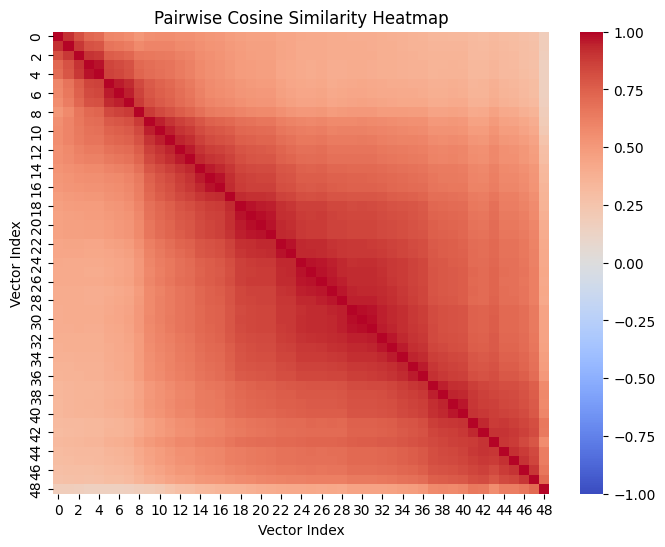

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to numpy for plotting
sim = sim.cpu().numpy()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(sim, cmap="coolwarm", annot=False, vmin=-1, vmax=1)
plt.title("Pairwise Cosine Similarity Heatmap")
plt.xlabel("Vector Index")
plt.ylabel("Vector Index")
plt.show()